In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
df = pd.read_csv('../data/processed/match_features_engineered.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"\n🏏 First Innings Score Statistics:")
print(df['innings1_total_runs'].describe())

print(f"\nScore range: {df['innings1_total_runs'].min():.0f} - {df['innings1_total_runs'].max():.0f}")

Dataset shape: (1095, 50)

🏏 First Innings Score Statistics:
count    1095.000000
mean      165.547032
std        32.062772
min        56.000000
25%       145.000000
50%       165.000000
75%       186.000000
max       287.000000
Name: innings1_total_runs, dtype: float64

Score range: 56 - 287


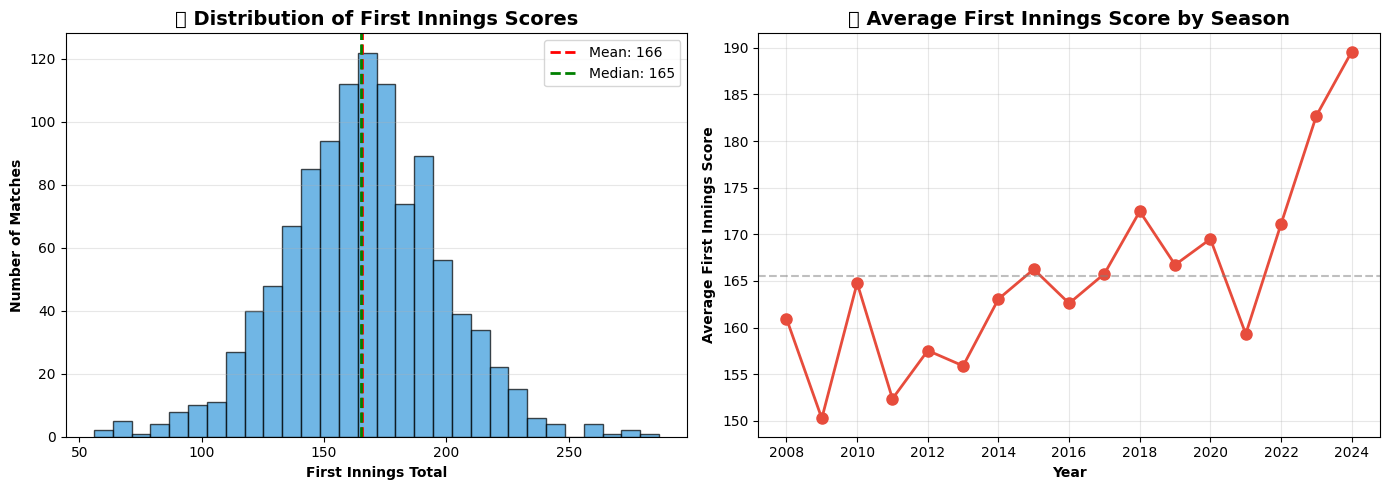

✓ Score distribution visualization saved!


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(df['innings1_total_runs'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(df['innings1_total_runs'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['innings1_total_runs'].mean():.0f}")
ax1.axvline(df['innings1_total_runs'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df['innings1_total_runs'].median():.0f}")
ax1.set_xlabel('First Innings Total', fontweight='bold')
ax1.set_ylabel('Number of Matches', fontweight='bold')
ax1.set_title('🏏 Distribution of First Innings Scores', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
df['year'] = df['date'].dt.year
yearly_avg = df.groupby('year')['innings1_total_runs'].mean()
ax2.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, color='#e74c3c', markersize=8)
ax2.set_xlabel('Year', fontweight='bold')
ax2.set_ylabel('Average First Innings Score', fontweight='bold')
ax2.set_title('🏏 Average First Innings Score by Season', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3)
ax2.axhline(y=df['innings1_total_runs'].mean(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../reports/figures/score_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Score distribution visualization saved!")

In [4]:
target = 'innings1_total_runs'

score_features = [
    'team1_form', 'team2_form', 'form_difference',
    'h2h_matches', 'team1_h2h_win_rate',
    'team1_venue_win_rate', 'team2_venue_win_rate',
    'team1_venue_matches', 'team2_venue_matches', 'venue_advantage',
    'team1_season_win_rate', 'team2_season_win_rate',
    'team1_season_matches', 'team2_season_matches', 'season_momentum_diff',
    'is_day_match', 'is_playoff',
    'team1_home', 'team2_home',
    'season'
]

print(f"Target variable: {target}")
print(f"\nFeatures for score prediction: {len(score_features)}")
print("\nFeatures:")
for i, f in enumerate(score_features, 1):
    print(f"  {i}. {f}")

Target variable: innings1_total_runs

Features for score prediction: 20

Features:
  1. team1_form
  2. team2_form
  3. form_difference
  4. h2h_matches
  5. team1_h2h_win_rate
  6. team1_venue_win_rate
  7. team2_venue_win_rate
  8. team1_venue_matches
  9. team2_venue_matches
  10. venue_advantage
  11. team1_season_win_rate
  12. team2_season_win_rate
  13. team1_season_matches
  14. team2_season_matches
  15. season_momentum_diff
  16. is_day_match
  17. is_playoff
  18. team1_home
  19. team2_home
  20. season


In [5]:
df_clean = df.dropna(subset=[target])

X = df_clean[score_features].copy()
y = df_clean[target].copy()

X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nMissing values: {X.isnull().sum().sum()}")

Feature matrix shape: (1095, 20)
Target shape: (1095,)

Missing values: 0


In [6]:
df_sorted = df_clean.sort_values('date').reset_index(drop=True)

split_idx = int(len(df_sorted) * 0.8)
split_date = df_sorted.iloc[split_idx]['date']

print(f"Temporal split at: {split_date.strftime('%Y-%m-%d')}")

train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

X_train = train_df[score_features].fillna(train_df[score_features].median())
X_test = test_df[score_features].fillna(test_df[score_features].median())
y_train = train_df[target]
y_test = test_df[target]

print(f"\nTraining set: {X_train.shape[0]} matches ({train_df['date'].dt.year.min()}-{train_df['date'].dt.year.max()})")
print(f" Test set: {X_test.shape[0]} matches ({test_df['date'].dt.year.min()}-{test_df['date'].dt.year.max()})")
print(f"\nTraining avg score: {y_train.mean():.1f} runs")
print(f"Test avg score: {y_test.mean():.1f} runs")

Temporal split at: 2022-03-26

Training set: 876 matches (2008-2021)
 Test set: 219 matches (2022-2024)

Training avg score: 161.7 runs
Test avg score: 181.0 runs


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Training mean: {X_train_scaled.mean():.6f}")
print(f"Training std: {X_train_scaled.std():.6f}")

Features scaled successfully!
Training mean: -0.000000
Training std: 0.974679


In [8]:
print("="*60)
print("MODEL 1: LINEAR REGRESSION (Baseline)")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\n📊 Performance Metrics:")
print(f"  RMSE: {rmse_lr:.2f} runs")
print(f"  MAE: {mae_lr:.2f} runs")
print(f"  R² Score: {r2_lr:.4f}")

print(f"\n🏏 Cricket Interpretation:")
print(f"  Average prediction error: ±{mae_lr:.0f} runs")
print(f"  Model explains {r2_lr*100:.1f}% of score variance")

MODEL 1: LINEAR REGRESSION (Baseline)

📊 Performance Metrics:
  RMSE: 35.91 runs
  MAE: 28.35 runs
  R² Score: -0.1401

🏏 Cricket Interpretation:
  Average prediction error: ±28 runs
  Model explains -14.0% of score variance


In [9]:
print("="*60)
print("MODEL 2: RIDGE REGRESSION")
print("="*60)

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n📊 Performance Metrics:")
print(f"  RMSE: {rmse_ridge:.2f} runs")
print(f"  MAE: {mae_ridge:.2f} runs")
print(f"  R² Score: {r2_ridge:.4f}")

print(f"\n🏏 Cricket Interpretation:")
print(f"  Average prediction error: ±{mae_ridge:.0f} runs")

MODEL 2: RIDGE REGRESSION

📊 Performance Metrics:
  RMSE: 35.91 runs
  MAE: 28.34 runs
  R² Score: -0.1397

🏏 Cricket Interpretation:
  Average prediction error: ±28 runs


In [10]:
print("="*60)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*60)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n📊 Performance Metrics:")
print(f"  RMSE: {rmse_rf:.2f} runs")
print(f"  MAE: {mae_rf:.2f} runs")
print(f"  R² Score: {r2_rf:.4f}")

print(f"\n🏏 Cricket Interpretation:")
print(f"  Average prediction error: ±{mae_rf:.0f} runs")

MODEL 3: RANDOM FOREST REGRESSOR

📊 Performance Metrics:
  RMSE: 44.73 runs
  MAE: 34.23 runs
  R² Score: -0.7680

🏏 Cricket Interpretation:
  Average prediction error: ±34 runs


In [11]:

print("="*60)
print("MODEL 4: GRADIENT BOOSTING REGRESSOR")
print("="*60)

gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1,
                                      min_samples_split=10, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\n📊 Performance Metrics:")
print(f"  RMSE: {rmse_gb:.2f} runs")
print(f"  MAE: {mae_gb:.2f} runs")
print(f"  R² Score: {r2_gb:.4f}")

print(f"\n🏏 Cricket Interpretation:")
print(f"  Average prediction error: ±{mae_gb:.0f} runs")

MODEL 4: GRADIENT BOOSTING REGRESSOR

📊 Performance Metrics:
  RMSE: 53.76 runs
  MAE: 39.03 runs
  R² Score: -1.5549

🏏 Cricket Interpretation:
  Average prediction error: ±39 runs


In [12]:
print("="*60)
print("ANALYSIS: WHY MODELS ARE STRUGGLING")
print("="*60)

print("\n📊 Score Distribution Shift:")
print(f"  Training period (2008-2021) avg: {y_train.mean():.1f} runs")
print(f"  Test period (2022-2024) avg: {y_test.mean():.1f} runs")
print(f"  Difference: +{y_test.mean() - y_train.mean():.1f} runs")

print("\n🏏 Cricket Context:")
print("  - Impact Player rule introduced (extra batting depth)")
print("  - Flat pitches favoring batsmen")
print("  - Smaller boundaries in some venues")
print("  - More aggressive batting approach")
print("  - Better bats and equipment")

print("\n📈 Baseline Comparison:")
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"  If we just predicted training mean ({y_train.mean():.0f} runs):")
print(f"  RMSE: {baseline_rmse:.2f} runs")
print(f"  MAE: {baseline_mae:.2f} runs")

ANALYSIS: WHY MODELS ARE STRUGGLING

📊 Score Distribution Shift:
  Training period (2008-2021) avg: 161.7 runs
  Test period (2022-2024) avg: 181.0 runs
  Difference: +19.4 runs

🏏 Cricket Context:
  - Impact Player rule introduced (extra batting depth)
  - Flat pitches favoring batsmen
  - Smaller boundaries in some venues
  - More aggressive batting approach
  - Better bats and equipment

📈 Baseline Comparison:
  If we just predicted training mean (162 runs):
  RMSE: 38.81 runs
  MAE: 30.57 runs


In [13]:
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [rmse_lr, rmse_ridge, rmse_rf, rmse_gb],
    'MAE': [mae_lr, mae_ridge, mae_rf, mae_gb],
    'R² Score': [r2_lr, r2_ridge, r2_rf, r2_gb]
}

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n📊 All Models Performance:")
print(results_df.to_string(index=False))

best_model_idx = results_df['MAE'].idxmin()
print(f"\n🏆 Best Model: {results_df.loc[best_model_idx, 'Model']} with MAE of {results_df.loc[best_model_idx, 'MAE']:.2f} runs")

print("\n⚠️ Key Insight:")
print("  All models have negative R² due to significant score inflation")
print("  in recent IPL seasons (2022-2024). Pre-match features alone")
print("  cannot accurately predict exact scores without venue/pitch data.")

MODEL COMPARISON SUMMARY

📊 All Models Performance:
            Model    RMSE     MAE  R² Score
Linear Regression 35.9147 28.3488   -0.1401
 Ridge Regression 35.9087 28.3427   -0.1397
    Random Forest 44.7254 34.2289   -0.7680
Gradient Boosting 53.7648 39.0340   -1.5549

🏆 Best Model: Ridge Regression with MAE of 28.34 runs

⚠️ Key Insight:
  All models have negative R² due to significant score inflation
  in recent IPL seasons (2022-2024). Pre-match features alone
  cannot accurately predict exact scores without venue/pitch data.


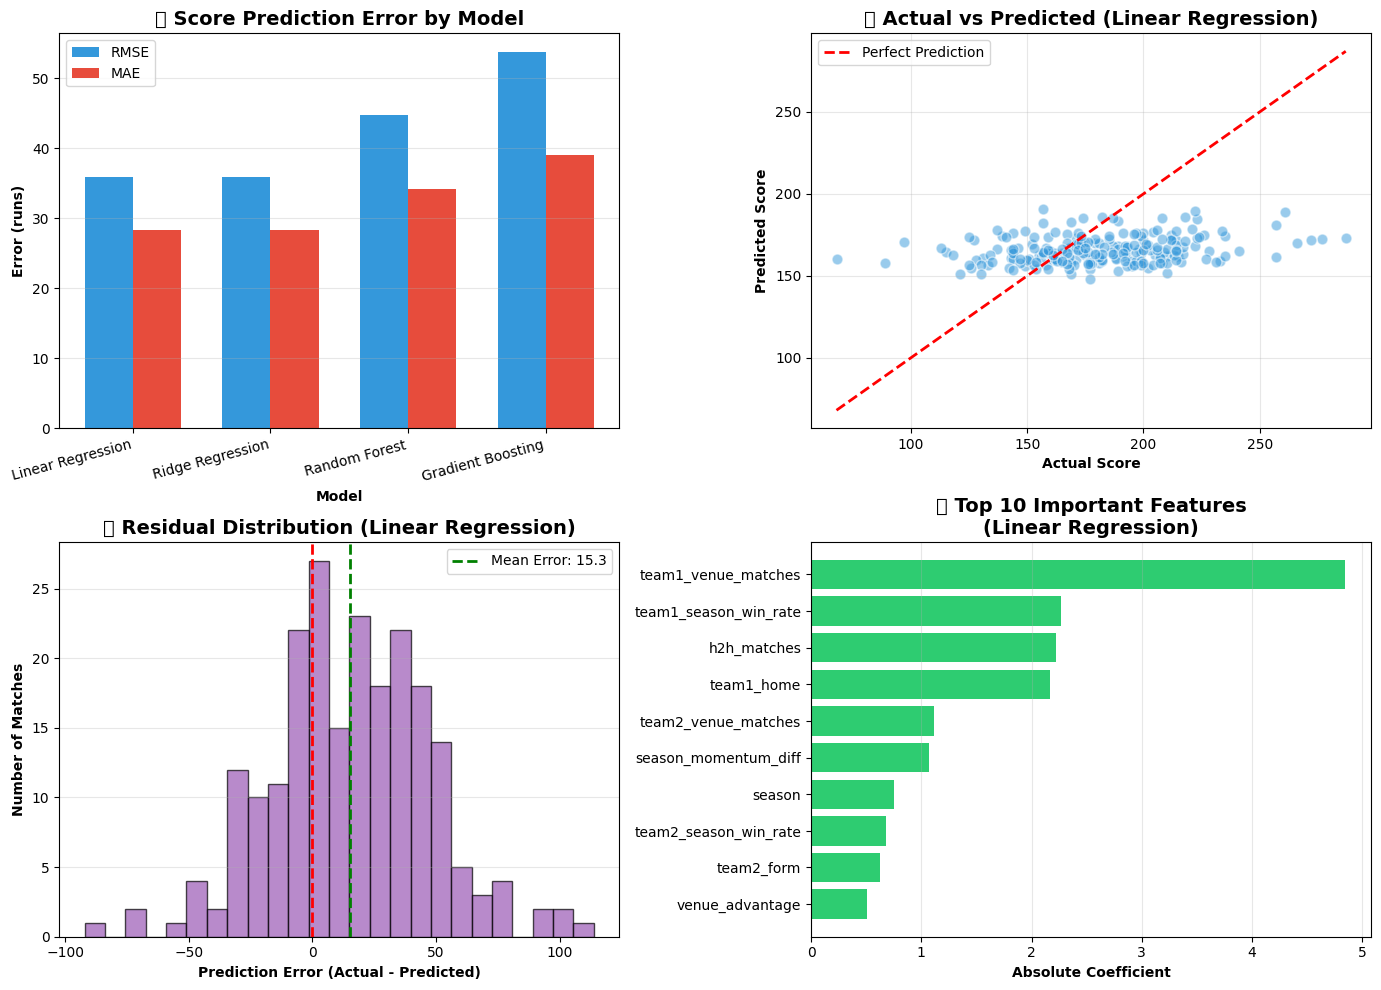

✓ Score prediction visualization saved!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

ax1 = axes[0, 0]
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='#3498db')
bars2 = ax1.bar(x + width/2, results_df['MAE'], width, label='MAE', color='#e74c3c')

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Error (runs)', fontweight='bold')
ax1.set_title('🏏 Score Prediction Error by Model', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred_lr, alpha=0.5, color='#3498db', edgecolors='white', s=60)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Score', fontweight='bold')
ax2.set_ylabel('Predicted Score', fontweight='bold')
ax2.set_title('🎯 Actual vs Predicted (Linear Regression)', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = axes[1, 0]
residuals = y_test - y_pred_lr
ax3.hist(residuals, bins=25, color='#9b59b6', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.axvline(x=residuals.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Error: {residuals.mean():.1f}')
ax3.set_xlabel('Prediction Error (Actual - Predicted)', fontweight='bold')
ax3.set_ylabel('Number of Matches', fontweight='bold')
ax3.set_title('📊 Residual Distribution (Linear Regression)', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 1]
feature_importance = pd.DataFrame({
    'Feature': score_features,
    'Coefficient': np.abs(lr_model.coef_)
}).sort_values('Coefficient', ascending=True).tail(10)

ax4.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='#2ecc71')
ax4.set_xlabel('Absolute Coefficient', fontweight='bold')
ax4.set_title('🔑 Top 10 Important Features\n(Linear Regression)', fontweight='bold', fontsize=14)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/score_prediction_results.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Score prediction visualization saved!")